In [1]:
#Imports

import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_validate
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
import csv
from lazypredict.Supervised import LazyRegressor
import lazypredict
from xgboost import XGBRegressor, plot_importance

In [3]:
# Data import and splitting into train and test
data = pd.read_csv(
    "C:\\Users\\nicke\\Downloads\\house_price_data\\train.csv"
)

train_data = data.sample(frac=0.8)
test_data = data.drop(train_data.index)

In [64]:
# Here is where we would split the data further into high and low price sectors

In [4]:
# Preprocessing

# Rename columns to age
train_data["BuildAge"] = 2025-train_data["YearBuilt"]
test_data["BuildAge"] = 2025-train_data["YearBuilt"]
train_data.drop("YearBuilt", axis=1)
test_data.drop("YearBuilt", axis=1)

train_data["RemodAge"] = 2025-train_data["YearRemodAdd"]
test_data["RemodAge"] = 2025-train_data["YearRemodAdd"]
train_data.drop("YearRemodAdd", axis=1)
test_data.drop("YearRemodAdd", axis=1)

# function to bin features and delete the original features
def bin(col, bins):
    for i in range(1, len(bins)):
        bin_label = f"{col}{bins[i - 1]}_{bins[i]}"
        train_data[bin_label] = ((train_data[col] >= bins[i - 1]) & (train_data[col] < bins[i])).astype(int)
        test_data[bin_label] = ((test_data[col] >= bins[i - 1]) & (test_data[col] < bins[i])).astype(int)
    train_data.drop(col, axis=1)
    test_data.drop(col, axis=1)

# Generate new features
train_data["GarageAreaPerCar"] = train_data["GarageArea"] / train_data["GarageCars"]
train_data["TotalBsmntBath"] = train_data["BsmtHalfBath"] + train_data["BsmtFullBath"]
train_data["TotalAboveBath"] = train_data["FullBath"] + train_data["HalfBath"]
train_data["TotalBath"] = train_data["TotalBsmntBath"] + train_data["FullBath"] + train_data["HalfBath"]
train_data["totalSQFT"] = train_data["GrLivArea"] + train_data["TotalBsmtSF"]

test_data["GarageAreaPerCar"] = test_data["GarageArea"] / test_data["GarageCars"]
test_data["TotalBsmntBath"] = test_data["BsmtHalfBath"] + test_data["BsmtFullBath"]
test_data["TotalAboveBath"] = test_data["FullBath"] + test_data["HalfBath"]
test_data["TotalBath"] = test_data["TotalBsmntBath"] + test_data["FullBath"] + test_data["HalfBath"]
test_data["totalSQFT"] = test_data["GrLivArea"] + test_data["TotalBsmtSF"]

# bin features based off the value ranges
bin("BuildAge", [0, 40, 80, 120, 140])
bin("LotFrontage", [21, 79, 139, 197, 255, 313])
bin(
    "LotArea",
    [
        1300,
        15563,
        29826,
        44089,
        58352,
        72615,
        86878,
        101141,
        115404,
        129667,
        143930,
        158193,
        172456,
        186719,
        200982,
        215245,
    ],
)
bin("1stFlrSF", [334, 1251, 2168, 3085, 4002, 4692])
bin("2ndFlrSF", [0, 500, 1000, 1500, 2065])
bin("GarageAreaPerCar", [150, 250, 350, 450, 550, 650, 750, 850, 950])
bin("totalSQFT", [0, 1_000, 2_000, 3_000, 4_000, 5_000, 6_000, 7_000, 8_000, 9_000, 10_000, 11_000, 12_000])

to_drop = ["Id", "BuildAge", "TotalBsmtSF", "LotFrontage", "LotArea", "1stFlrSF", "2ndFlrSF", "GarageAreaPerCar", "totalSQFT", "GarageArea", "GarageCars", 
           "BsmtHalfBath", "BsmtFullBath", "FullBath", "HalfBath", "TotalBsmntBath",]
train_data.drop(to_drop, axis=1)
test_data.drop(to_drop, axis=1)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,totalSQFT2000_3000,totalSQFT3000_4000,totalSQFT4000_5000,totalSQFT5000_6000,totalSQFT6000_7000,totalSQFT7000_8000,totalSQFT8000_9000,totalSQFT9000_10000,totalSQFT10000_11000,totalSQFT11000_12000
0,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,1,0,0,0,0,0,0,0,0,0
4,60,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,1,0,0,0,0,0,0,0,0
19,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,1,0,0,0,0,0,0,0,0,0
21,45,RM,Pave,Grvl,Reg,Bnk,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,0,0,0,0,0,0
23,120,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,120,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,0,0,0,0,0
1447,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,1,0,0,0,0,0,0,0,0
1450,90,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,...,1,0,0,0,0,0,0,0,0,0
1453,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,1,0,0,0,0,0,0,0,0,0


In [5]:
# Preprocessing Part 2

def remove_outliers(datagram, feature):
    if feature not in datagram.columns:
        print(f"Warning: '{feature}' column not found in the dataset")
        return datagram
    
    Q1 = datagram[feature].quantile(0.25)
    Q3 = datagram[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    return datagram[
        (datagram[feature] >= lower_bound) & (datagram[feature] <= upper_bound)
    ]
#define qualitative columns
qualitative_columns = train_data.select_dtypes(include=['object']).columns.tolist()

# Define numeric columns
numeric_cols = [col for col in train_data.columns if col not in qualitative_columns]


# Fill NA values in numeric columns with their respective medians
for col in numeric_cols:
    if col in train_data.columns:
        if train_data[col].dtype in ['int64', 'float64']:
            train_data[col] = train_data[col].fillna(train_data[col].median())
            if col in test_data.columns:
                test_data[col] = test_data[col].fillna(train_data[col].median())

label_encoders = {}
# Fill missing values in categorical columns with "NA" before encoding
for col in qualitative_columns:
    if col in train_data.columns:
        train_data[col] = train_data[col].fillna("NA")
        if col in test_data.columns:
            test_data[col] = test_data[col].fillna("NA")

# Use OrdinalEncoder to handle unseen categories
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
train_data[qualitative_columns] = encoder.fit_transform(train_data[qualitative_columns])
test_data[qualitative_columns] = encoder.fit_transform(test_data[qualitative_columns])

# Convert to int if necessary
train_data[qualitative_columns] = train_data[qualitative_columns].astype(int)
test_data[qualitative_columns] = test_data[qualitative_columns].astype(int)

# Fill any remaining NaN values with -1
train_data.fillna(-1, inplace=True)
test_data.fillna(-1, inplace=True)


# First, fill missing values in categorical columns
for col in qualitative_columns:
    if col in train_data.columns:
        # Fill missing values with mode (most frequent value)
        mode_val = train_data[col].mode()[0]
        train_data[col] = train_data[col].fillna(mode_val)
        if col in test_data.columns:
            mode_val = test_data[col].mode()[0]
            test_data[col] = test_data[col].fillna(mode_val)

# Then apply LabelEncoder
for col in qualitative_columns:
    if col in train_data.columns and train_data[col].dtype == "object":
        try:
            le = LabelEncoder()
            train_data[col] = le.fit_transform(train_data[col].astype(str))
            if col in test_data.columns:
                test_data[col] = le.fit_transform(test_data[col].astype(str))
            label_encoders[col] = le
        except Exception as e:
            print(f"Error processing column {col}: {e}")


train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)

train_data.fillna(-1, inplace=True)
test_data.fillna(-1, inplace=True)

columns = train_data.columns

print("\nProcessing complete. Final train data shape:", train_data.shape)
scaler = MinMaxScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns=columns)

for col in numeric_cols:
    train_data = remove_outliers(train_data, col)


Processing complete. Final train data shape: (1168, 141)


Cross-Validation Training Metrics (Mean):
MAE: 0.0132, MSE: 0.0005, R²: 0.9235

Cross-Validation Validation Metrics (Mean):
MAE: 0.0253, MSE: 0.0016, R²: 0.7344

Final Test Set Metrics:
MAE: 0.0378, MSE: 0.0040, R²: 0.6811


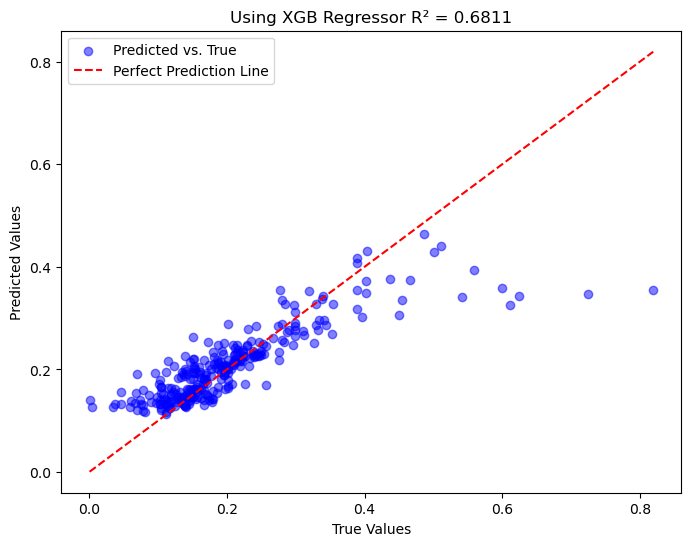

Cross-Validation Training Metrics (Mean):
MAE: 0.0086, MSE: 0.0003, R²: 0.9598

Cross-Validation Validation Metrics (Mean):
MAE: 0.0238, MSE: 0.0014, R²: 0.7629

Final Test Set Metrics:
MAE: 0.0311, MSE: 0.0025, R²: 0.7950


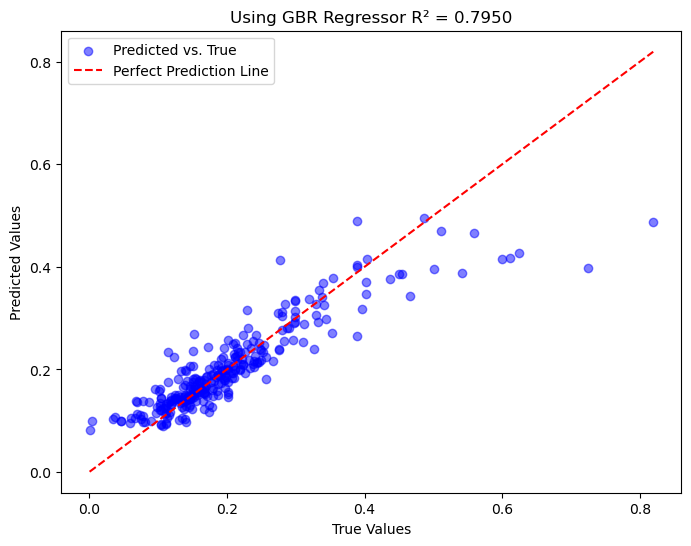

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# Cross Validation

# Define Inputs and Output Fields
Inputs = [col for col in train_data.columns if col != "SalePrice"]
Output = ["SalePrice"]

X_train = train_data[Inputs]
y_train = train_data[Output].values.ravel()  # Convert to 1D array for compatibility

X_test = test_data[Inputs]  # Assuming test_data has the same columns

# Initialize cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store metrics for each fold
train_mae_list, train_mse_list, train_r2_list = [], [], []
val_mae_list, val_mse_list, val_r2_list = [], [], []

# K-Fold Cross Validation
for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Initialize model
    modelXGB = XGBRegressor(objective='reg:squarederror', alpha = 0.5, eta=0.1, random_state=42)
    
    # Train the model
    modelXGB.fit(X_train_fold, y_train_fold)
    
    # Predictions on training and validation sets
    y_train_predXGB = modelXGB.predict(X_train_fold)
    y_val_predXGB = modelXGB.predict(X_val_fold)

    # Calculate metrics for training
    train_mae_list.append(mean_absolute_error(y_train_fold, y_train_predXGB))
    train_mse_list.append(mean_squared_error(y_train_fold, y_train_predXGB))
    train_r2_list.append(r2_score(y_train_fold, y_train_predXGB))

    # Calculate metrics for validation
    val_mae_list.append(mean_absolute_error(y_val_fold, y_val_predXGB))
    val_mse_list.append(mean_squared_error(y_val_fold, y_val_predXGB))
    val_r2_list.append(r2_score(y_val_fold, y_val_predXGB))

# Train the final model on the full dataset
final_modelXGB = XGBRegressor(objective='reg:squarederror', alpha = 0.1, eta=0.1, random_state=42)
final_modelXGB.fit(X_train, y_train)

# Predict on the test set
y_test_pred = final_modelXGB.predict(X_test)


# Compute metrics on the test set
test_mae = mean_absolute_error(test_data["SalePrice"], y_test_pred)
test_mse = mean_squared_error(test_data["SalePrice"], y_test_pred)
test_r2 = r2_score(test_data["SalePrice"], y_test_pred)

# Print average cross-validation results
print("Cross-Validation Training Metrics (Mean):")
print(f"MAE: {np.mean(train_mae_list):.4f}, MSE: {np.mean(train_mse_list):.4f}, R²: {np.mean(train_r2_list):.4f}")

print("\nCross-Validation Validation Metrics (Mean):")
print(f"MAE: {np.mean(val_mae_list):.4f}, MSE: {np.mean(val_mse_list):.4f}, R²: {np.mean(val_r2_list):.4f}")

# Print test set performance
print("\nFinal Test Set Metrics:")
print(f"MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

test_y = test_data["SalePrice"]
y_pred = y_test_pred
#graph r2 score of the model
plt.figure(figsize=(8, 6))
plt.scatter(test_y, y_pred, color='blue', alpha=0.5, label='Predicted vs. True')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'Using XGB Regressor R² = {test_r2:.4f}')
plt.legend()
plt.show()


#using GBR regressor ---------000000000000000000000000000000000000000000000000000000000000000000000000000-----------------------------------------------


# K-Fold Cross Validation
for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Initialize model
    modelGBR = GradientBoostingRegressor(loss = 'squared_error', learning_rate=0.1, max_depth = 4, random_state=12)
    
    # Train the model
    modelGBR.fit(X_train_fold, y_train_fold)
    
    # Predictions on training and validation sets
    y_train_predGBR = modelGBR.predict(X_train_fold)
    y_val_predGBR = modelGBR.predict(X_val_fold)

    # Calculate metrics for training
    train_mae_list.append(mean_absolute_error(y_train_fold, y_train_predGBR))
    train_mse_list.append(mean_squared_error(y_train_fold, y_train_predGBR))
    train_r2_list.append(r2_score(y_train_fold, y_train_predGBR))

    # Calculate metrics for validation
    val_mae_list.append(mean_absolute_error(y_val_fold, y_val_predGBR))
    val_mse_list.append(mean_squared_error(y_val_fold, y_val_predGBR))
    val_r2_list.append(r2_score(y_val_fold, y_val_predGBR))

# Train the final model on the full dataset
final_modelGBR = GradientBoostingRegressor(loss = 'squared_error', learning_rate=0.1, max_depth = 4, random_state=12)
final_modelGBR.fit(X_train, y_train)

# Predict on the test set
y_test_pred = final_modelGBR.predict(X_test)


# Compute metrics on the test set
test_mae = mean_absolute_error(test_data["SalePrice"], y_test_pred)
test_mse = mean_squared_error(test_data["SalePrice"], y_test_pred)
test_r2 = r2_score(test_data["SalePrice"], y_test_pred)

# Print average cross-validation results
print("Cross-Validation Training Metrics (Mean):")
print(f"MAE: {np.mean(train_mae_list):.4f}, MSE: {np.mean(train_mse_list):.4f}, R²: {np.mean(train_r2_list):.4f}")

print("\nCross-Validation Validation Metrics (Mean):")
print(f"MAE: {np.mean(val_mae_list):.4f}, MSE: {np.mean(val_mse_list):.4f}, R²: {np.mean(val_r2_list):.4f}")

# Print test set performance
print("\nFinal Test Set Metrics:")
print(f"MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

test_y = test_data["SalePrice"]
y_pred = y_test_pred
#graph r2 score of the model
plt.figure(figsize=(8, 6))
plt.scatter(test_y, y_pred, color='blue', alpha=0.5, label='Predicted vs. True')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'Using GBR Regressor R² = {test_r2:.4f}')
plt.legend()
plt.show()




In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(train_data, columns=train_data.columns)
